# part 1: KNN iplementation

## grid search

In [3]:
df = get_knn_grid()
pivot_table = df.pivot(index='k', columns='metric', values='accuracy')

In [4]:
pivot_table

metric        l1        l2
k                         
1       0.967044  0.968043
10      0.961718  0.957723
100     0.923103  0.920107
1000    0.745007  0.741678
3000    0.401798  0.398136

its clear that increasing the number of neighbours worsened the accuracy, but the real drop happens after 100. this stands to reason - as the K grows, the modell has to take into account more neighbours thus increasing the chance that the prediciton for a city in a small state will be dominatted by the larger states nearby (consider that with 3000 neighbours, every city is being predicted based on an >10% of the entire US)
in our L2 performed consistnetly but slightly worse than l1

### KNN decision boundaries



we used `plot_decision_boundaries()` helper to visualize 3 models on test data:
1. L2 distance, k = k_max (highest test accuracy)
2. L2 distance, k = k_min (lowest test accuracy)  
3. L1 distance, k = k_max
```
k_min, k_max = 3000, 1
# ---------------------------------------------------------
# Plot 1: Metric = L2, k = kmax (1)
# ---------------------------------------------------------
xknn_l2_best = KNNClassifier(k=k_max, distance_metric='l2')
knn_l2_best.fit(X_train, Y_train)
plot_decision_boundaries(knn_l2_best, X_test, Y_test, title=f"Metric: L2, k={k_max} (Best Acc)")
```
we did the same for l1 with `k_max`, and for l2 with `k_min`

then we saved the results and dispalyed them side by side

**3000 vs 1:**  
we see much larger boundaries for K=300. any small state gets 'overwhelmed' by the neighbours because the model has to find 3000 cities for the prediciton.

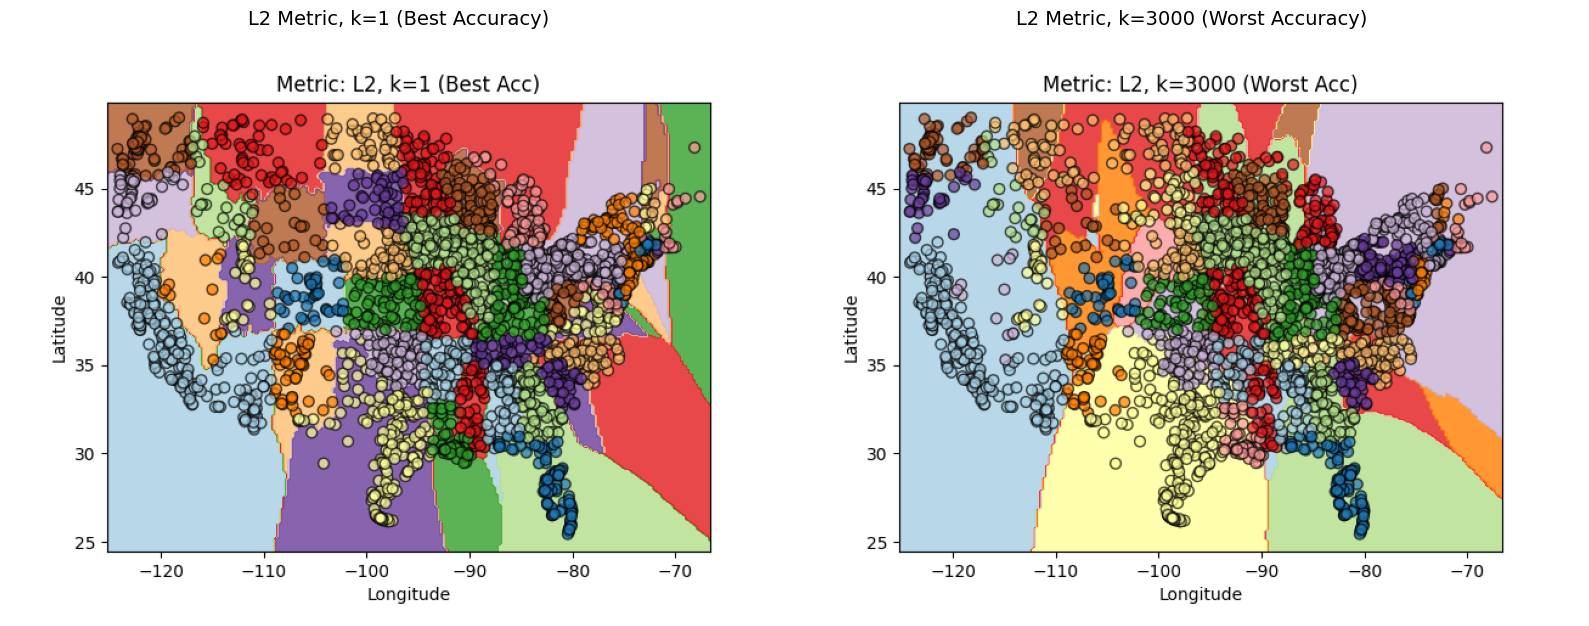

In [5]:
show_comparison(
    'boundares_l2_k1.png',    'L2 Metric, k=1 (Best Accuracy)',
    'boundares_l2_k3000.png', 'L2 Metric, k=3000 (Worst Accuracy)'
)

**l2 vs l1**:  
in L1 the boundaries tend to be smooth lines. the difference seems mostly in the 'empty' spaces. especially in the bottom left.

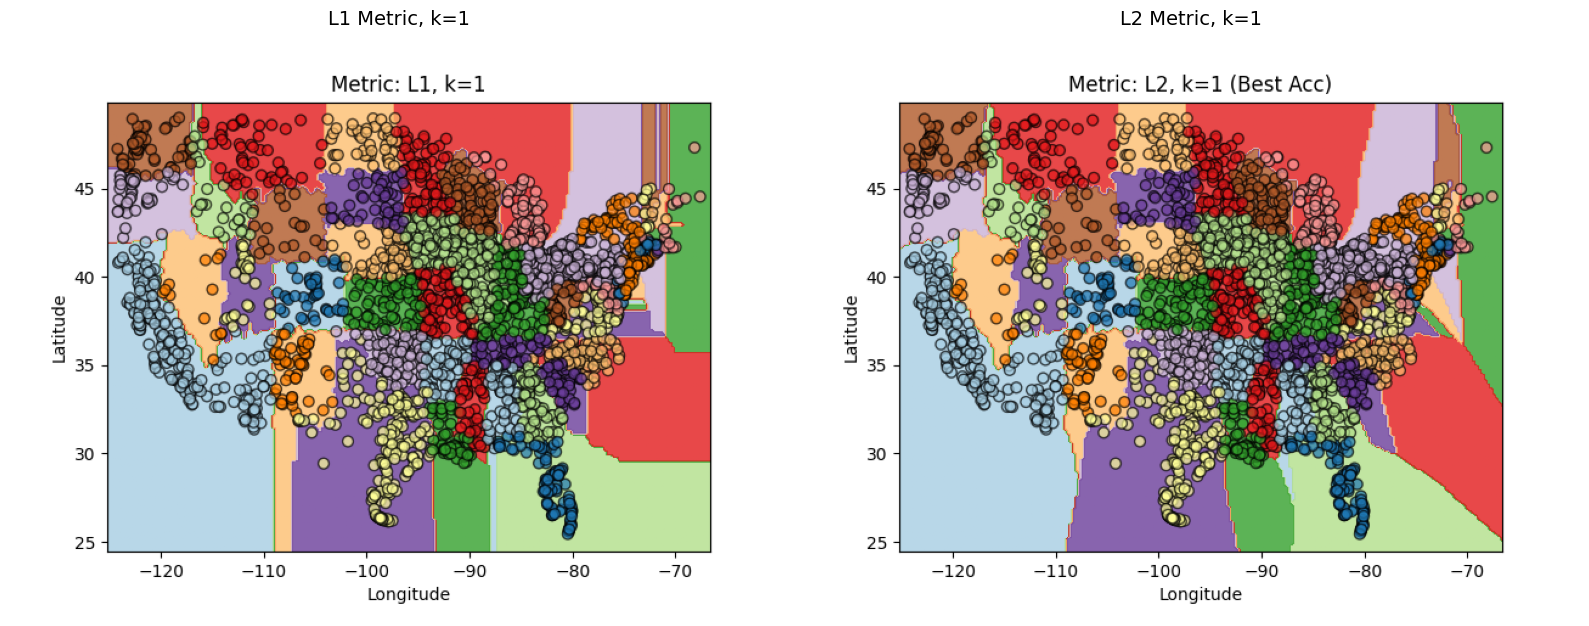

In [6]:

show_comparison(
    'boundares_l1_k1.png', 'L1 Metric, k=1',
    'boundares_l2_k1.png', 'L2 Metric, k=1'
)

## Anomaly detection: top 50 by sum of L2 distance
**Question:** What characterizes the anomalies? How do they differ from normal data?

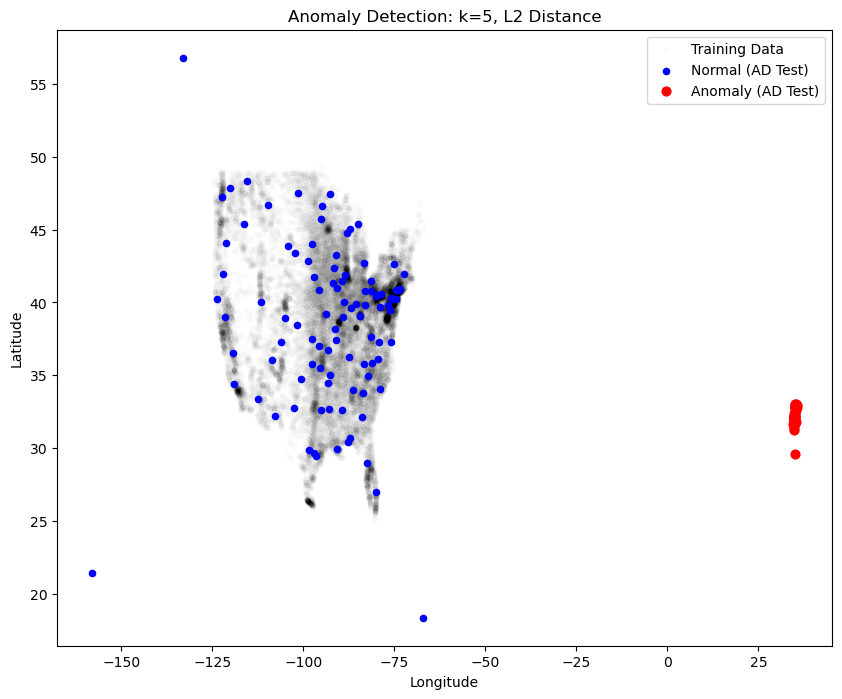

In [7]:
plot_anomalies()

visualing makes it clear the anomalies are outside the US! (in isreal). were we to increase the number of anomalies by 2, we would get the other two outliers (hawai?)

# trees

Extract the arrays that define the tree
**feature**: which feature index (0 or 1) to check at this node. -2 indicates a leaf.
toy_tree.tree_.feature -> `array([ 0,  1, -2, -2,  1, -2, -2], dtype=int64)`

the structure is clear: root checks feature 0, left and right children check feature 1 (latitude).

**threshold**: the value to compare against.
```
toy_tree.tree_.threshold
array([-115.80725098,   39.24810028,   -2.        ,   -2.        ,
         33.63225174,   -2.        ,   -2.        ])
```

the threshold param holds the value at each node. 
hence, the comaprison is:

```
        feat_idx = feature[node_id]
        thresh = threshold[node_id]
        sample_val = sample_point[feat_idx]
        if sample_val <= thresh:
            print("    YES -> Go Left")
```

### summary

each level of the tree passses another straight line through the feature space, deviding it into two additional subspaces. 
at each level, the tree searches for the line that maximally reduces number of classes per box (reduce gini). 

Eventually, the tree stops splitting a specific box. This happens if:
- The box is "pure" (only contains one state). (gini = 0 -> pure). 
- We reached max_depth.
- We don't have enough samples left to justify a split (min_samples_leaf).

When it stops, that box becomes a Leaf.


note that there are two params here:
the `max_depth` (how many devisions) and `max_leaf_nodes` (how many leaves in the entire tree). 

bottom line:
trees devide feature space into rectangles, and majority vote in the rectangle. 
a tee can never recognise more classes than there are leaves. 

## train 24 trees

all combinations of max_depth ∈ {1, 2, 4, 6, 10, 20, 50, 100} × max_leaf_nodes ∈ {50, 100, 1000}.

In [8]:
saved_models, df_trees = get_24_trees()

Starting Grid Search...


In [9]:
# Sort by test_acc descending
df_trees['gap']  = df_trees['train_acc']-df_trees['test_acc']
df_sorted = df_trees.sort_values(by='test_acc', ascending=False)

## tree analysis

### question 1: best overal

In [10]:
# 1. Best Tree Overall (Based on Validation Accuracy)
best_overall_row = df_trees.sort_values(by='val_acc', ascending=False).iloc[0]
best_tree_model = saved_models[(best_overall_row['max_depth'], best_overall_row['max_leaf_nodes'])]
tree_idx = best_overall_row.name
print(f"--- Q1: Best Overall Tree --- at index {tree_idx} had a test accuracy of  {best_overall_row['test_acc']:.4f}")
print(f"Params: Depth={best_overall_row['max_depth']}, Leaves={best_overall_row['max_leaf_nodes']}")


--- Q1: Best Overall Tree --- at index 23 had a test accuracy of  0.9790
Params: Depth=100.0, Leaves=1000.0


### Question 2: estimation from validation or test?

In [11]:
print(f'the generalisation gap was {best_overall_row['gap']:.4f}, suggesting the model generalised well')

the generalisation gap was 0.0210, suggesting the model generalised well


in general, find the test and validation are well correlated with train:

In [12]:
# Select the columns of interest and check correlation
cols = ['train_acc', 'val_acc', 'test_acc']

corr_matrix = df_trees[cols].corr(); print(corr_matrix)
mean_gap, gap_std = df_trees['gap'].mean(),df_trees['gap'].std(),
print(f'for each tree, the mean and std of generalisation gap was {mean_gap} and {gap_std}')

           train_acc   val_acc  test_acc
train_acc   1.000000  0.999950  0.999993
val_acc     0.999950  1.000000  0.999951
test_acc    0.999993  0.999951  1.000000
for each tree, the mean and std of generalisation gap was 0.01173593222528461 and 0.008573946756964736


we see that training and test accuracy as just as correleated at training and val, indicating that val is an equally good estamte of generalisation, and they are alomost perfectly correlated with each other. this is as expected for large data, where we didn't select any model based on val. we also see that across all 24 trees, the generalisation gap was under 0.027. 

### Question 3: are 50 leaves enough?

each level of the tree passses another straight line through the feature space, dividing it into two additional subspaces.   
at each level, the tree searches for the line that maximally reduces number of classes per box (reduce gini), and at leaf nodes it predicts most common class in the rectangle.  
**to be able to predict N classes**, a tree needs to have at **at least N leaves**. but that is only sufficient if the data could be perfectly divided by exactly N rectangles. this is only the case if each class was completely concave. since this isn't the case (ie, state borders aren't smooth lines), more than 50 leaves will be needed. 


### Question 4: how trees see

Plotting Q4: Best Overall Tree...


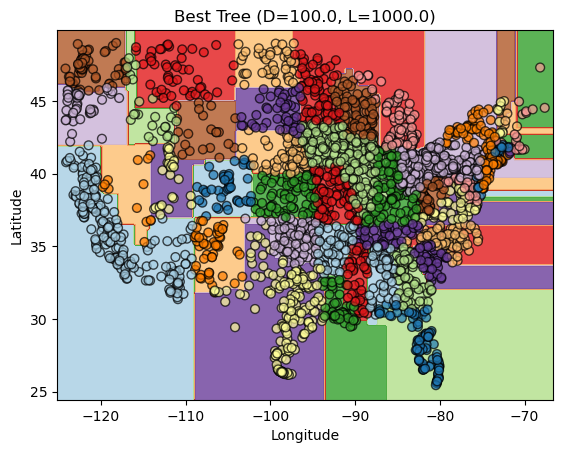

In [13]:
# Q4: Visualize Best Overall Tree
print("Plotting Q4: Best Overall Tree...")
plot_decision_boundaries(best_tree_model, X_test, Y_test, 
                         title=f"Best Tree (D={best_overall_row['max_depth']}, L={best_overall_row['max_leaf_nodes']})")

as expected, it has devided the map into rectangles. 

### Quetsion 5: Restricted leaves: 50 leaf prediciton

In [14]:
# 2. Best Tree with Restricted Leaves (max_leaf_nodes = 50)
df_50_leaves = df_trees[df_trees['max_leaf_nodes'] == 50]
best_50_row = df_50_leaves.sort_values(by='val_acc', ascending=False).iloc[0]
best_50_model = saved_models[(best_50_row['max_depth'], best_50_row['max_leaf_nodes'])]

print(f"\n--- Q5: Best Tree with 50 Leaves ---")
print(f"Params: Depth={best_50_row['max_depth']}")
print(f"Validation Acc: {best_50_row['val_acc']:.4f}")


--- Q5: Best Tree with 50 Leaves ---
Params: Depth=50.0
Validation Acc: 0.8445


Plotting Q5: Restricted Leaves (50)...
Plot saved to restricted_leaves_(leaf=50,_d=50.0).png


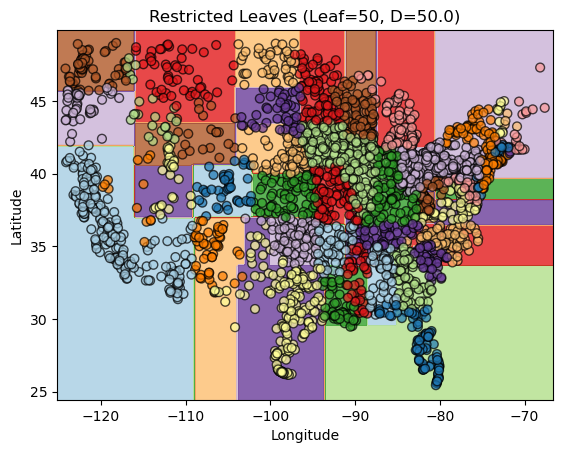

In [15]:
# Q5: Visualize Restricted Leaves (50)
print("Plotting Q5: Restricted Leaves (50)...")
plot_decision_boundaries(best_50_model, X_test, Y_test, 
                         title=f"Restricted Leaves (Leaf=50, D={best_50_row['max_depth']})",save=True)

we see there are larger boxes as comapered to the best model (see top left), meaning the model can must make coarser predictions. 
what we are seeing is exactly the difference the thoeretical minimal number of leaves and the actual number of leaves needed. to understand this intuitively we can visualise the boxes the model uses for prediction

In [ ]:
# Pick a random index from the test set
sample_idx = 8 
# Use the best_tree_model we found earlier (or any trained model)
visualize_leaf_box(best_50_model, X_test, Y_test, sample_idx,save=True,title = 'best_50_leaf_tree_sample_8')
visualize_leaf_box(best_tree_model, X_test, Y_test, sample_idx,save=True,title = 'best_tree_sample_8')

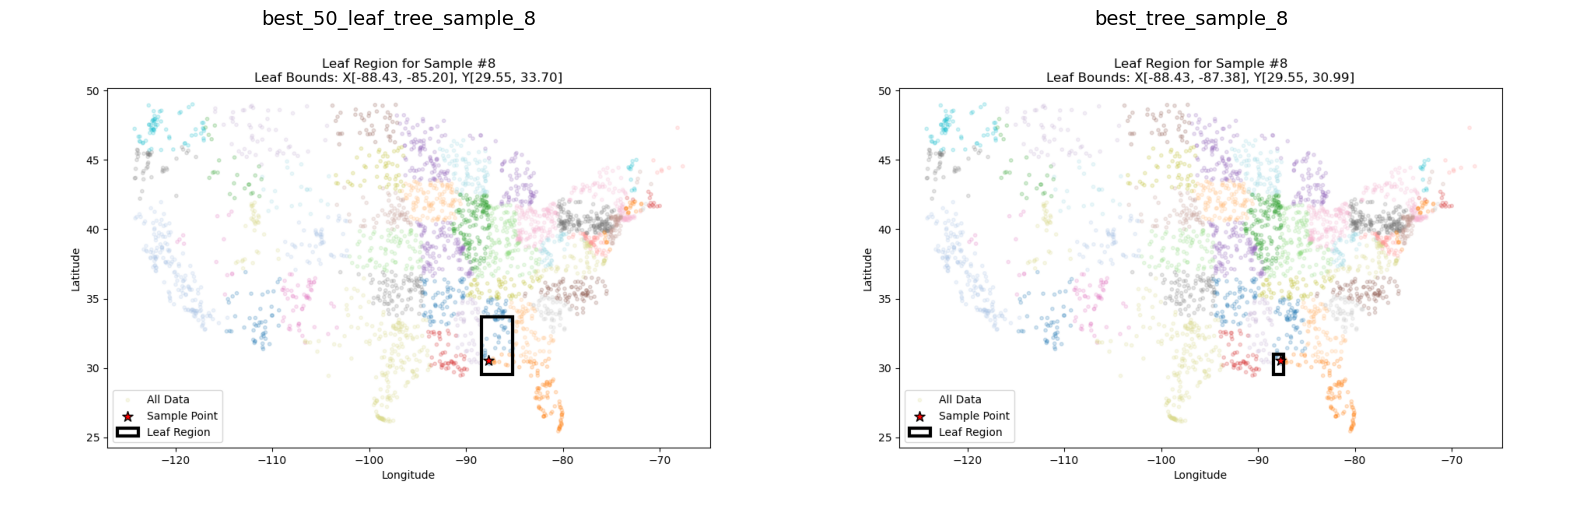

In [17]:

show_comparison(
    'best_50_leaf_tree_sample_8.png', 'best_50_leaf_tree_sample_8',
    'best_tree_sample_8.png', 'best_tree_sample_8'
)

we clearly see that with more leaves, the model can assign a specific smaple to a much finer part of the grid, allowing for purer leaf nodes.

### question 6: best shallow tree

In [18]:
# 3. Best Tree with Restricted Depth (max_depth <= 6)
df_shallow = df_trees[df_trees['max_depth'] <= 6]
best_shallow_row = df_shallow.sort_values(by='val_acc', ascending=False).iloc[0]
best_shallow_model = saved_models[(best_shallow_row['max_depth'], best_shallow_row['max_leaf_nodes'])]

print(f"\n--- Q6: Best Tree with Depth <= 6 ---")
print(f"Params: Depth={best_shallow_row['max_depth']}, Leaves={best_shallow_row['max_leaf_nodes']}")
print(f"Validation Acc: {best_shallow_row['val_acc']:.4f}")


--- Q6: Best Tree with Depth <= 6 ---
Params: Depth=6.0, Leaves=50.0
Validation Acc: 0.5806


despite having 50 leaves, the accuracy is much lower, as can be seen in the pivot table:

In [19]:
# Rows = max_depth, Columns = max_leaf_nodes, Values = test_acc
pivot_table = df_trees.pivot(index='max_depth', columns='max_leaf_nodes', values='test_acc')
# Use a heatmap style background to instantly spot the best values
pivot_table.style.background_gradient(cmap='viridis')

clearly somewhere between depth 6 and 10, there is an optimal 50 recatngles, that can't be imporved by any depth. this indicates that using rectangles (trees) to overlay the boundaries, requires additional leaves to allow perfect prediction. we see that even with 100 leaves, there is an upper bound of 0.93 on test accuracy. 


In [ ]:
# Q6: Visualize Restricted Depth (<=6)
print("Plotting Q6: Restricted Depth (<=6)...")
plot_decision_boundaries(best_shallow_model, X_test, Y_test, 
                         title=f"Restricted Depth (D={best_shallow_row['max_depth']})",save=True)

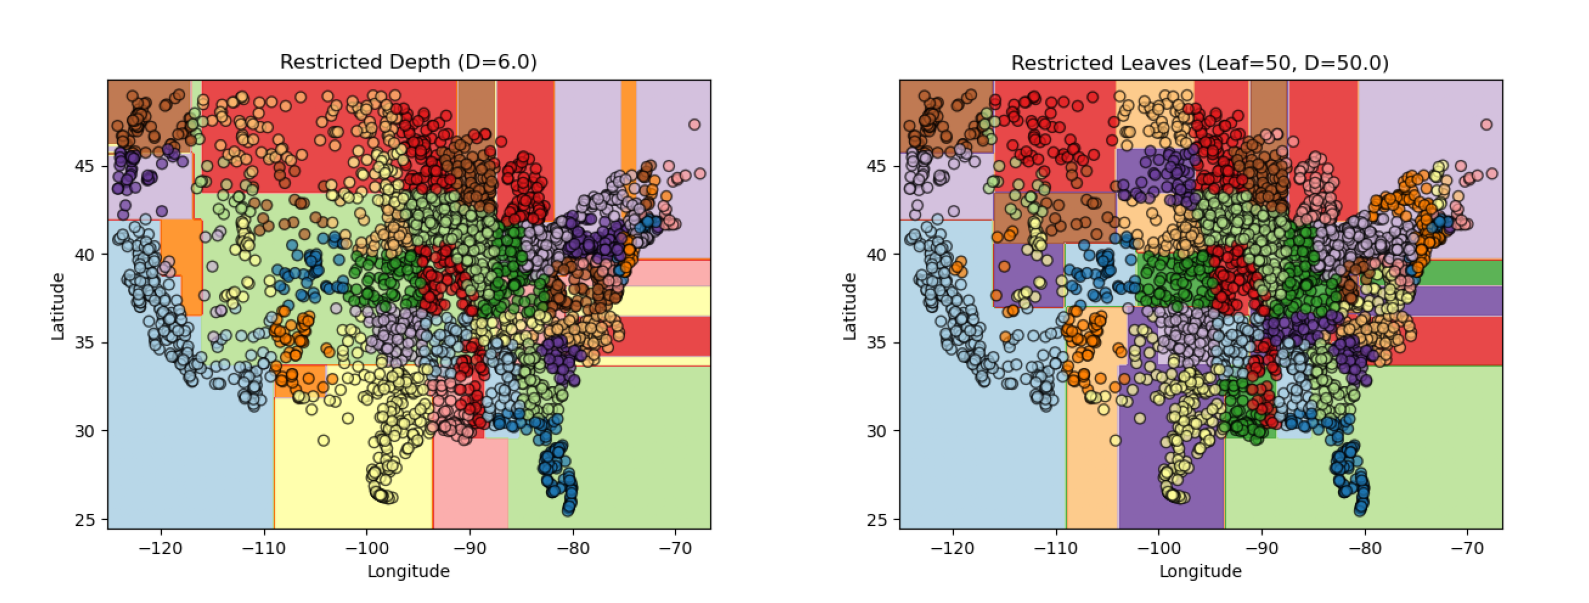

In [28]:

show_comparison(
    'restricted_depth_(d=6.0).png', '',
    'restricted_leaves_(leaf=50,_d=50.0).png', ''
)

we beleive the model is worse because it doesn't ahve enough nodes to create the 50 best partitions. when we visualise the tree, we see that many leaves come from central paths. ie, the model can't have suffciently 'specialised' branches that would alllow it to reach all 50 best partitions. 
in this case, the tree can't reach the limit of 0.83, since with a depth of 6, the tree is limited in how it can devide the data.

#### tree visualisation

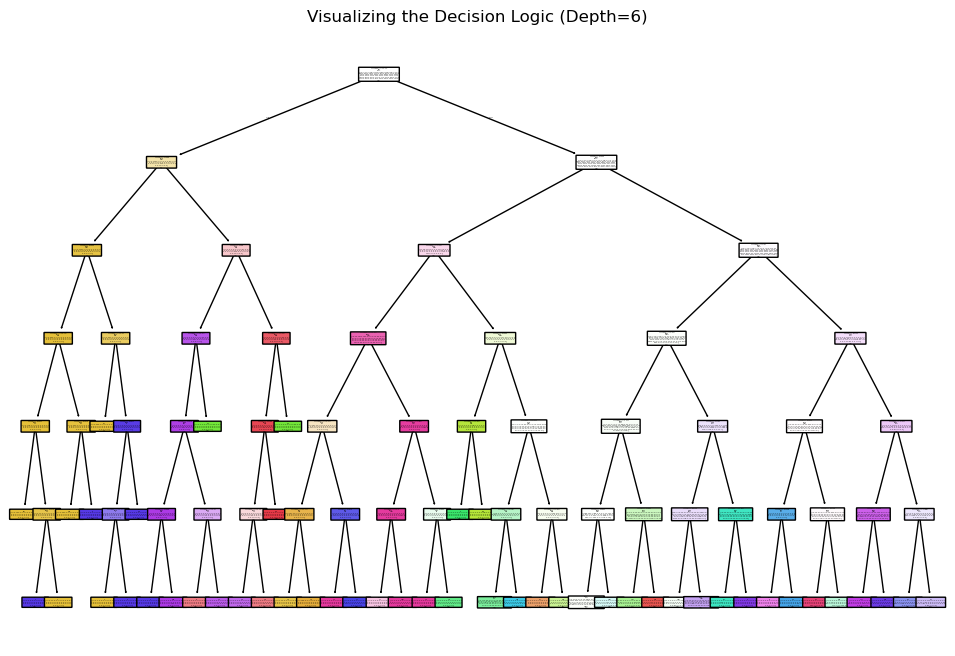

In [22]:

best_shallow_model

plt.figure(figsize=(12, 8))
plot_tree(best_shallow_model, 
          filled=True, 
          label ='none',
          feature_names=['Longitude', 'Latitude'], 
          class_names=True,
          rounded=True)
plt.title("Visualizing the Decision Logic (Depth=6)")
plt.show()

we compare to the best model with 50 leaves and see that it can afford to 'waste' many brnaches

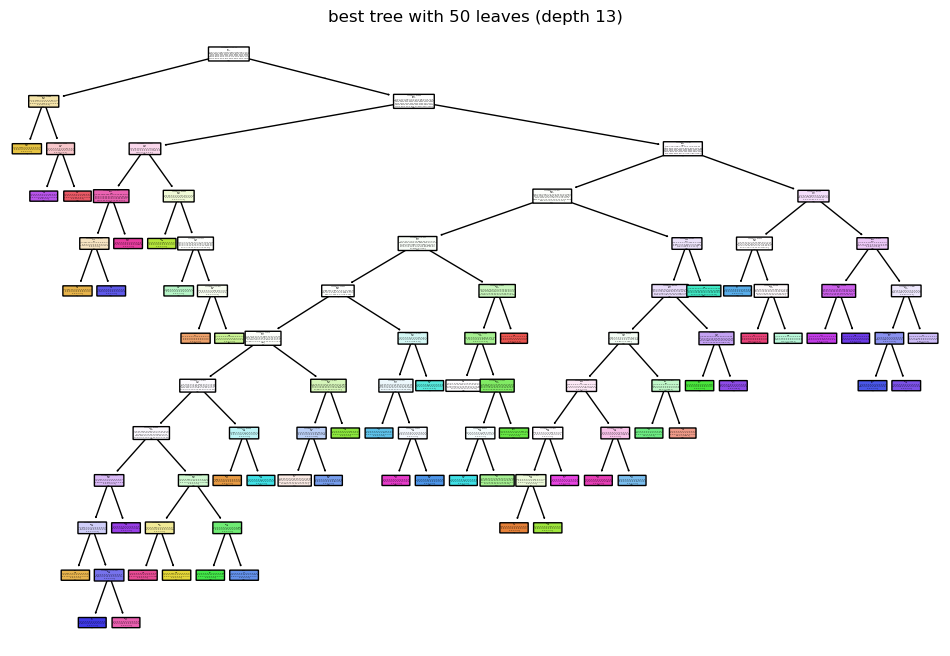

In [23]:

plt.figure(figsize=(12, 8))
plot_tree(best_50_model, 
          filled=True, 
          label ='none',
          feature_names=['Longitude', 'Latitude'], 
          class_names=True,
          rounded=True)
plt.title("best tree with 50 leaves (depth 13)")
plt.show()

## Question 7: random forest

Random Forest Accuracy: 0.8083


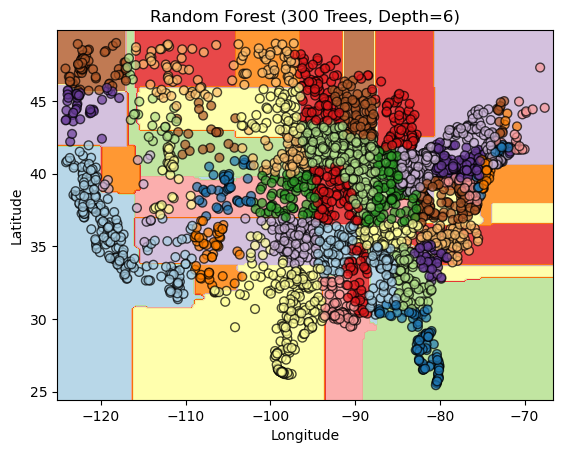

In [24]:
# Initialize Random Forest
rf = loading_random_forest()
rf.fit(X_train, Y_train)

acc_rf = rf.score(X_test, Y_test)
print(f"Random Forest Accuracy: {acc_rf:.4f}")

# Visualize
plot_decision_boundaries(rf, X_test, Y_test, title="Random Forest (300 Trees, Depth=6)")

qouting from the documentation of the predict method:
> The predicted class of an input sample is a vote by the trees in
the forest, weighted by their probability estimates. That is,
the predicted class is the one with highest mean probability
estimate across the trees.

thus, even though no tree can reach the best 50 leaves possible with a greater depth, the classifier can sample enough different trees that the confidence weighted sum allows it reach a slightly different set of leaves. 

# bonus: boosted trees

Training XGBoost...
XGBoost Test Accuracy: 0.9650
Plotting XGBoost Boundaries...


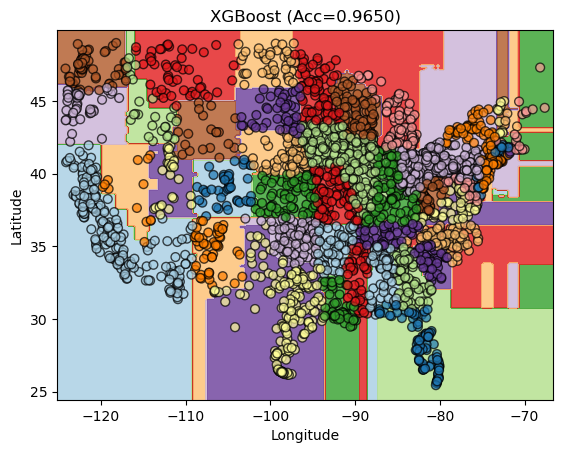

In [25]:
xgb_model,Y_test_enc,X_test = get_fitted_xgb()
xgb_acc = xgb_model.score(X_test, Y_test_enc)
print(f"XGBoost Test Accuracy: {xgb_acc:.4f}")
# 4. Visualize
print("Plotting XGBoost Boundaries...")
plot_decision_boundaries(xgb_model, X_test, Y_test_enc, 
                         title=f"XGBoost (Acc={xgb_acc:.4f})")

we see that the xgb classifier outperfomrs the RF. I beleive this is due to the differnce in expressivity. the boundaries of the RF are composed of randomly trained trees. in xgb, each tree is trained to improve upon the existing model, honing in on exiswting weakneses.